# Visualizing SVCCA Results

## Investigating within and across z Algorithm Stability

**Gregory Way 2018**

Visualizing the stability of compression algorithms across different bottleneck dimensionalities.
This notebook visualizes the output generated from `3.within-z-svcca-analysis.ipynb`.

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(RColorBrewer))

In [2]:
# Define the dataset to compile results for
svcca_file <- file.path("results", "svcca_mean_correlation_within_z.tsv.gz")
svcca_df <- readr::read_tsv(svcca_file,
                            col_types = readr::cols(
                                .default = readr::col_character(),
                                svcca_mean_similarity = readr::col_double()))
head(svcca_df, 2)

seed_1,seed_2,algorithm_1,algorithm_2,svcca_mean_similarity,dataset,z_dim,shuffled
242178,320346,pca,pca,0.5467526,TARGET,2,signal
242178,320346,pca,ica,0.5489489,TARGET,2,signal


In [3]:
 # Make sure factors are in order
svcca_df$z_dim <- factor(
    svcca_df$z_dim,
    levels = sort(as.numeric(paste(unique(svcca_df$z_dim))))
)

algorithms <- c("pca", "ica", "nmf", "dae", "vae")

svcca_df$algorithm_1 <- factor(
    svcca_df$algorithm_1,
    levels = algorithms
)

svcca_df$algorithm_2 <- factor(
    svcca_df$algorithm_2,
    levels = algorithms
)

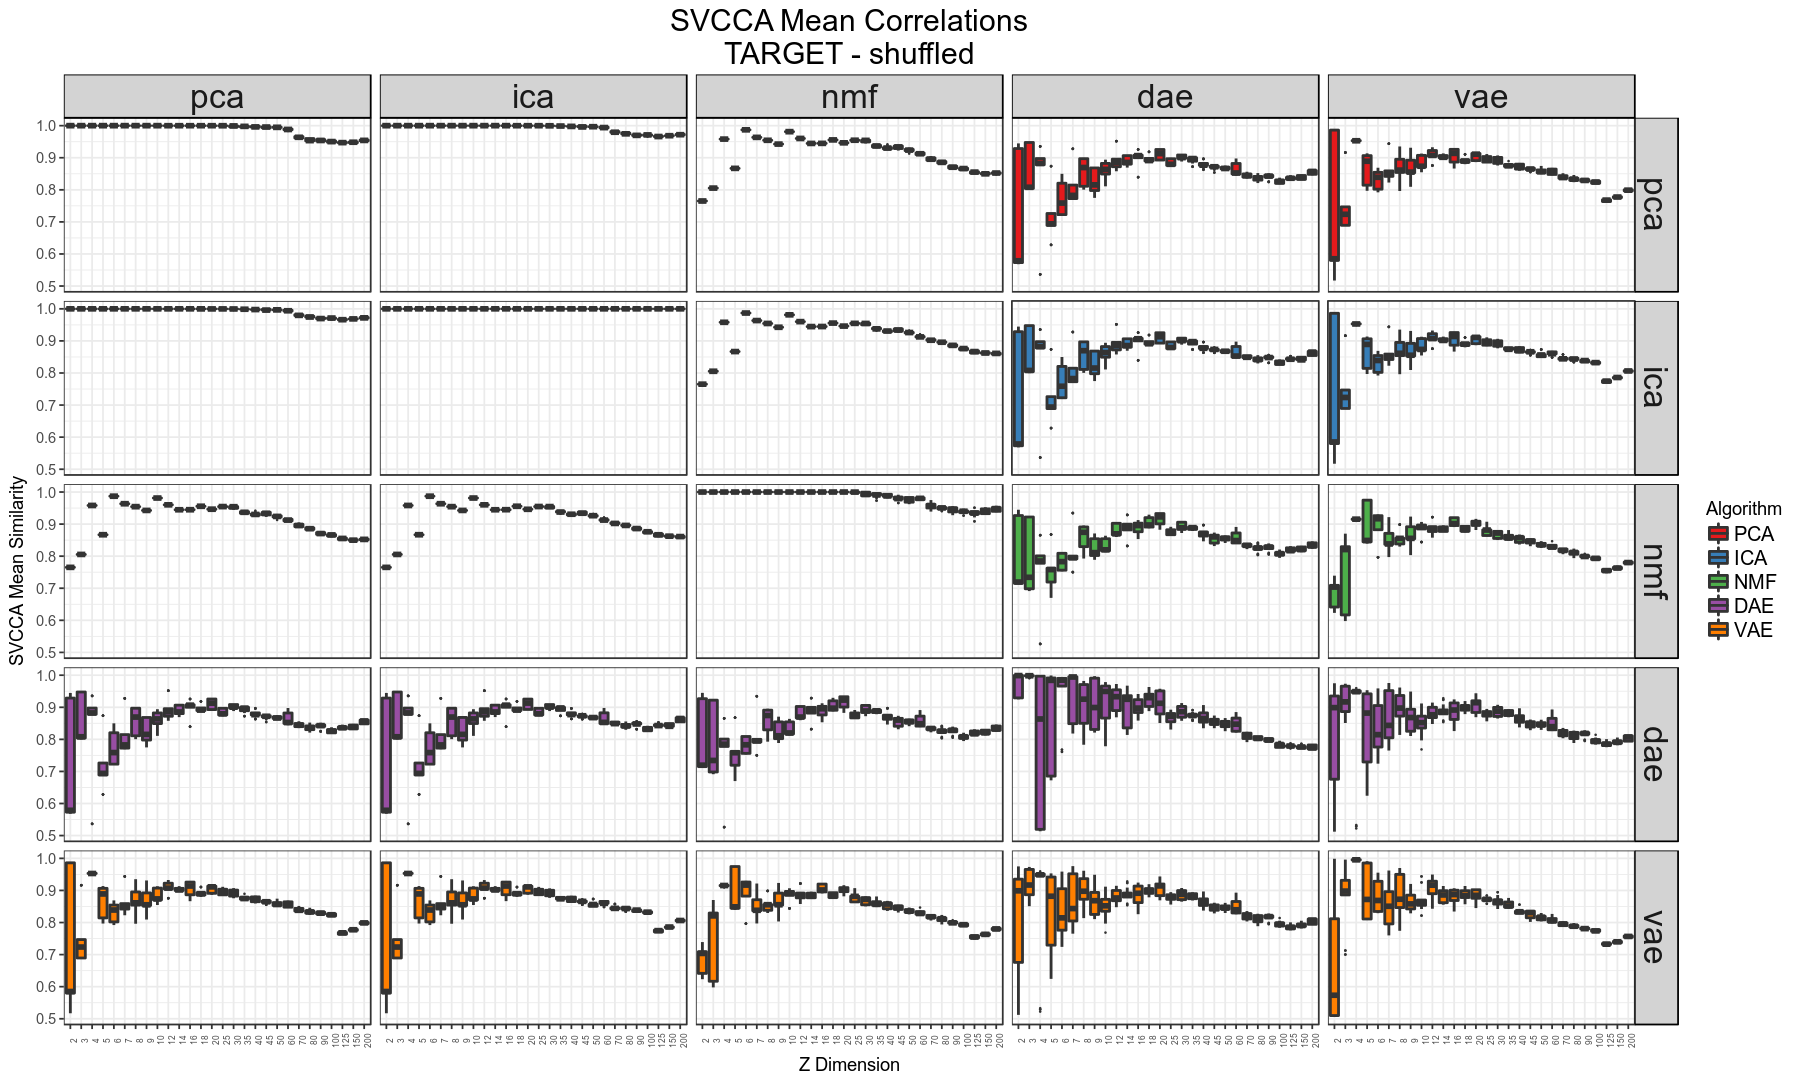

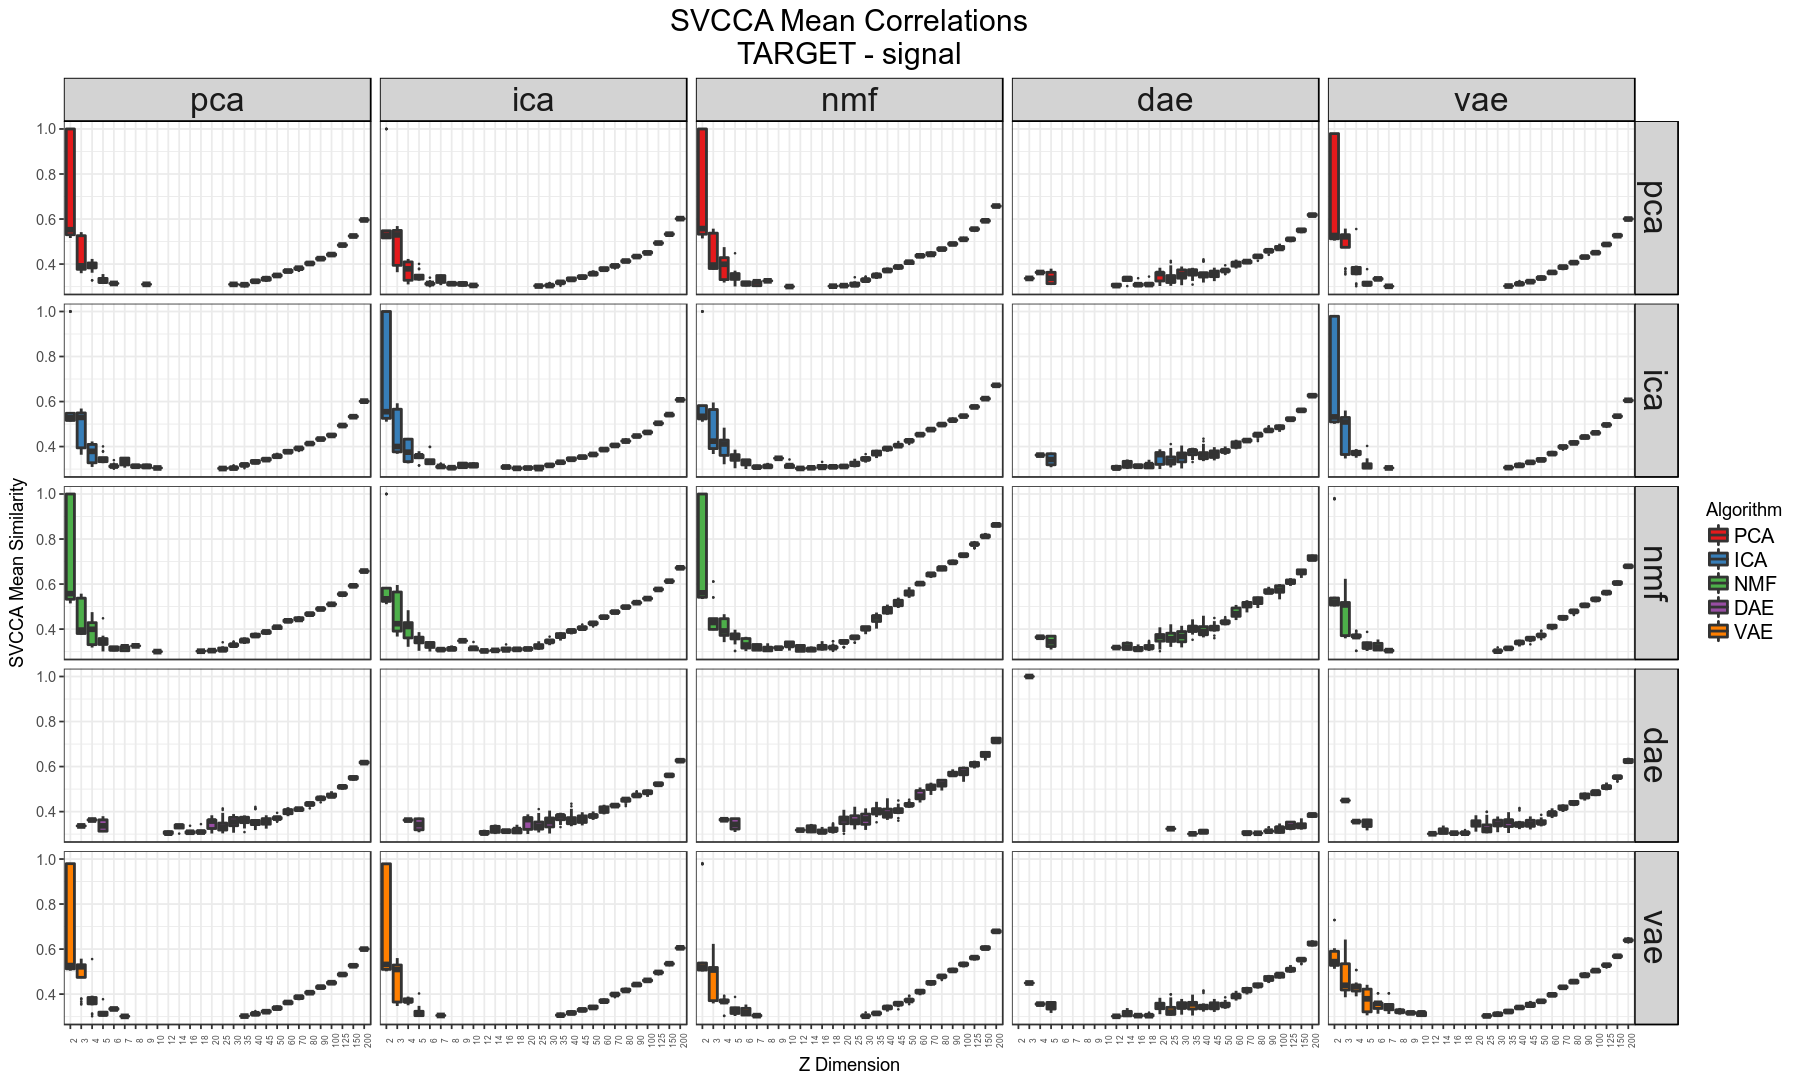

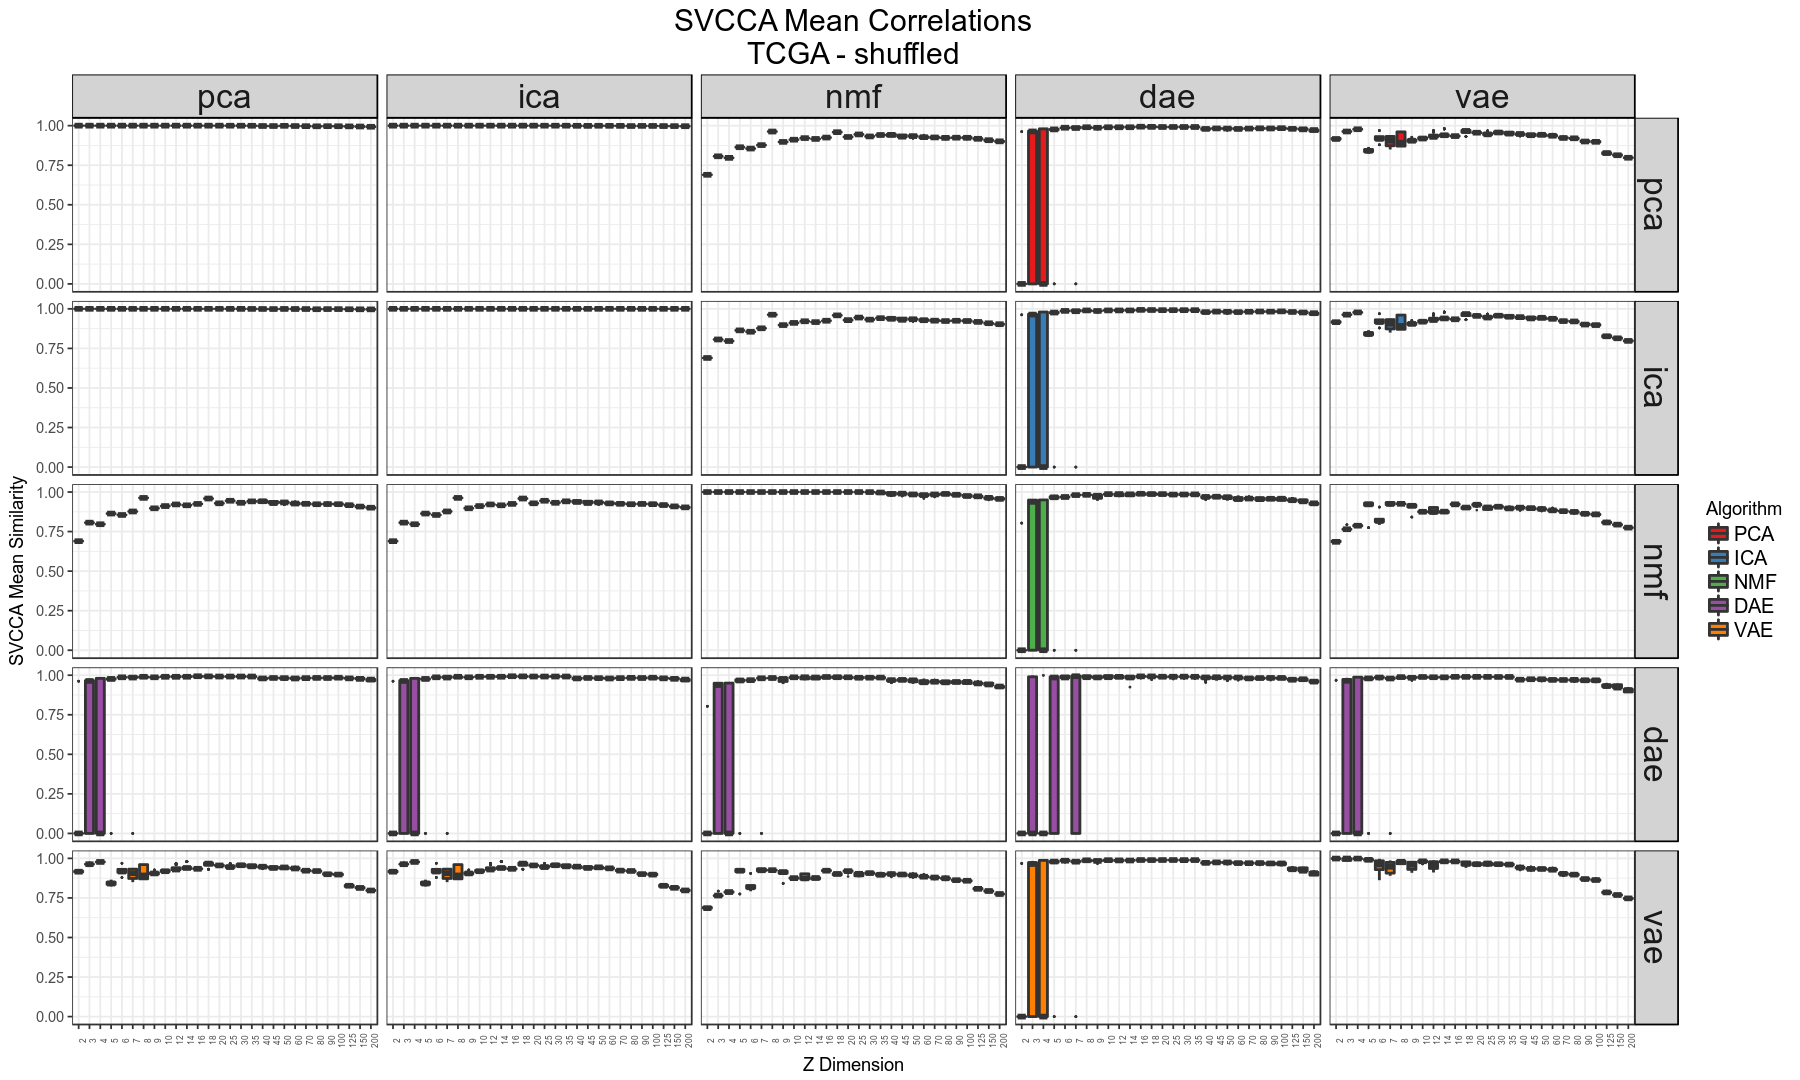

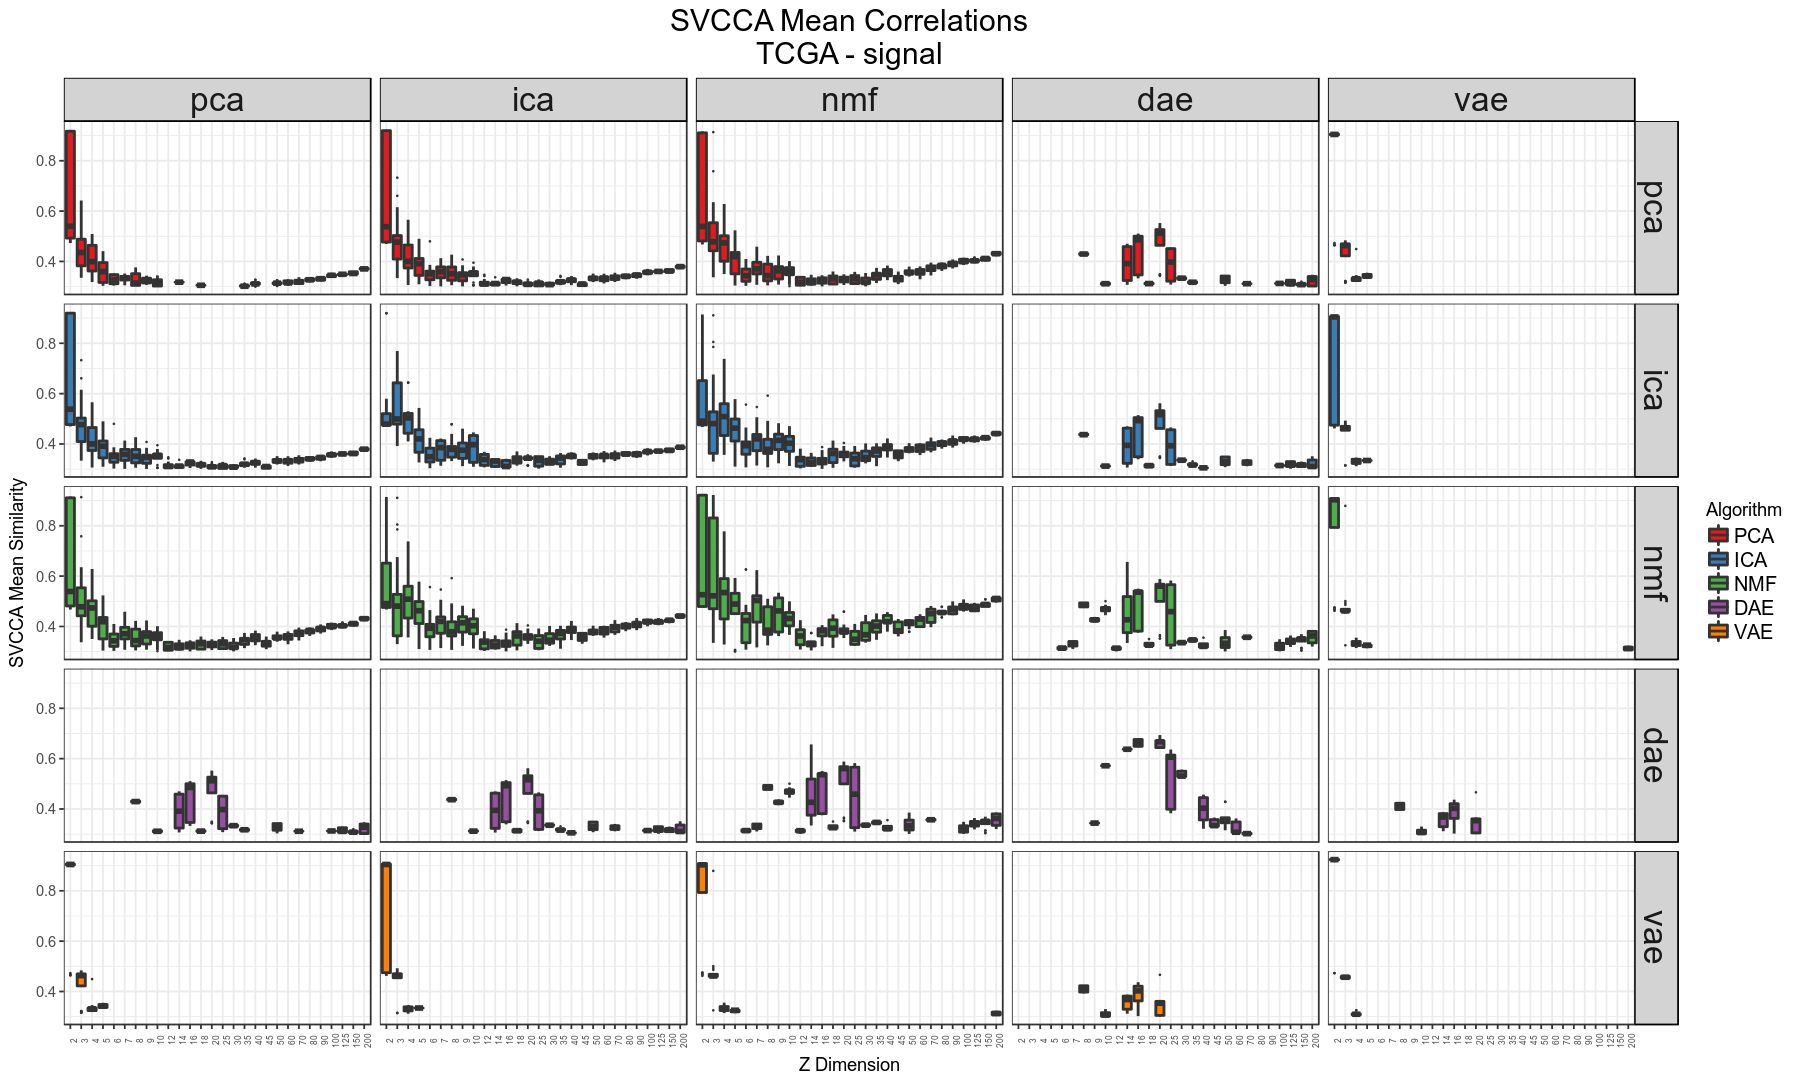

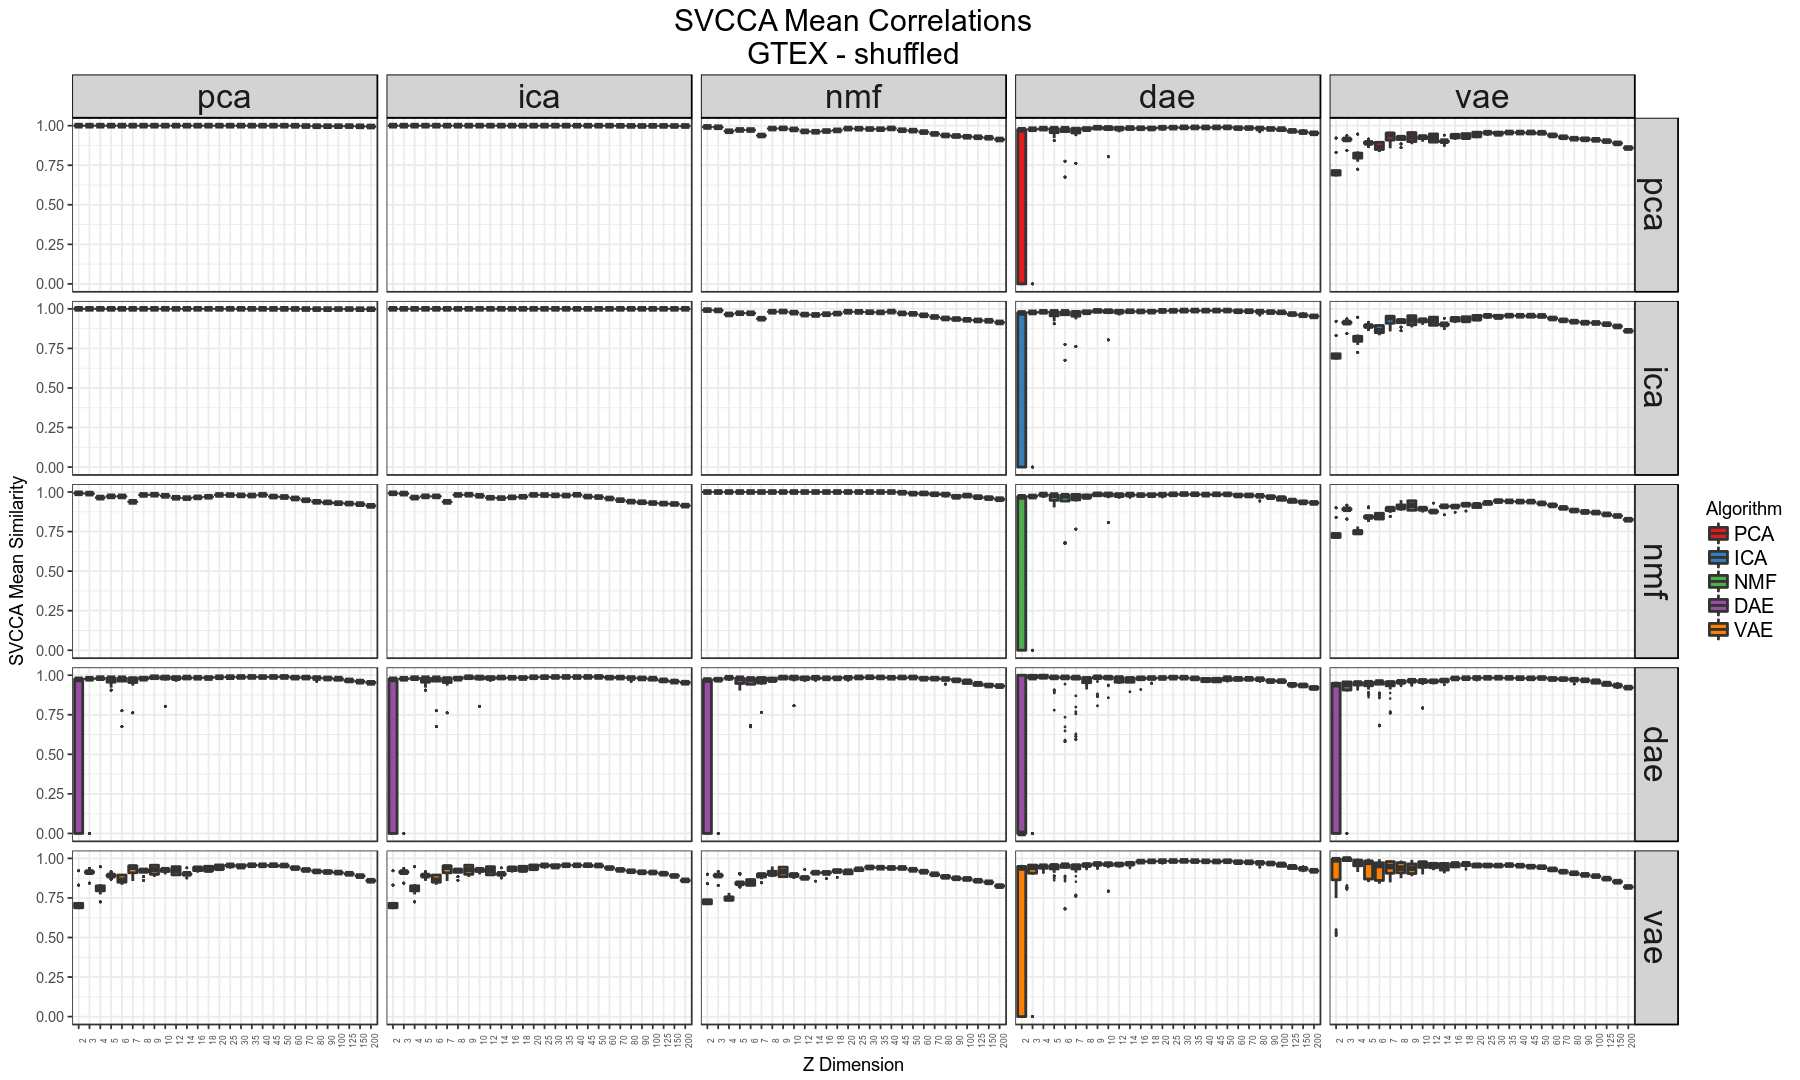

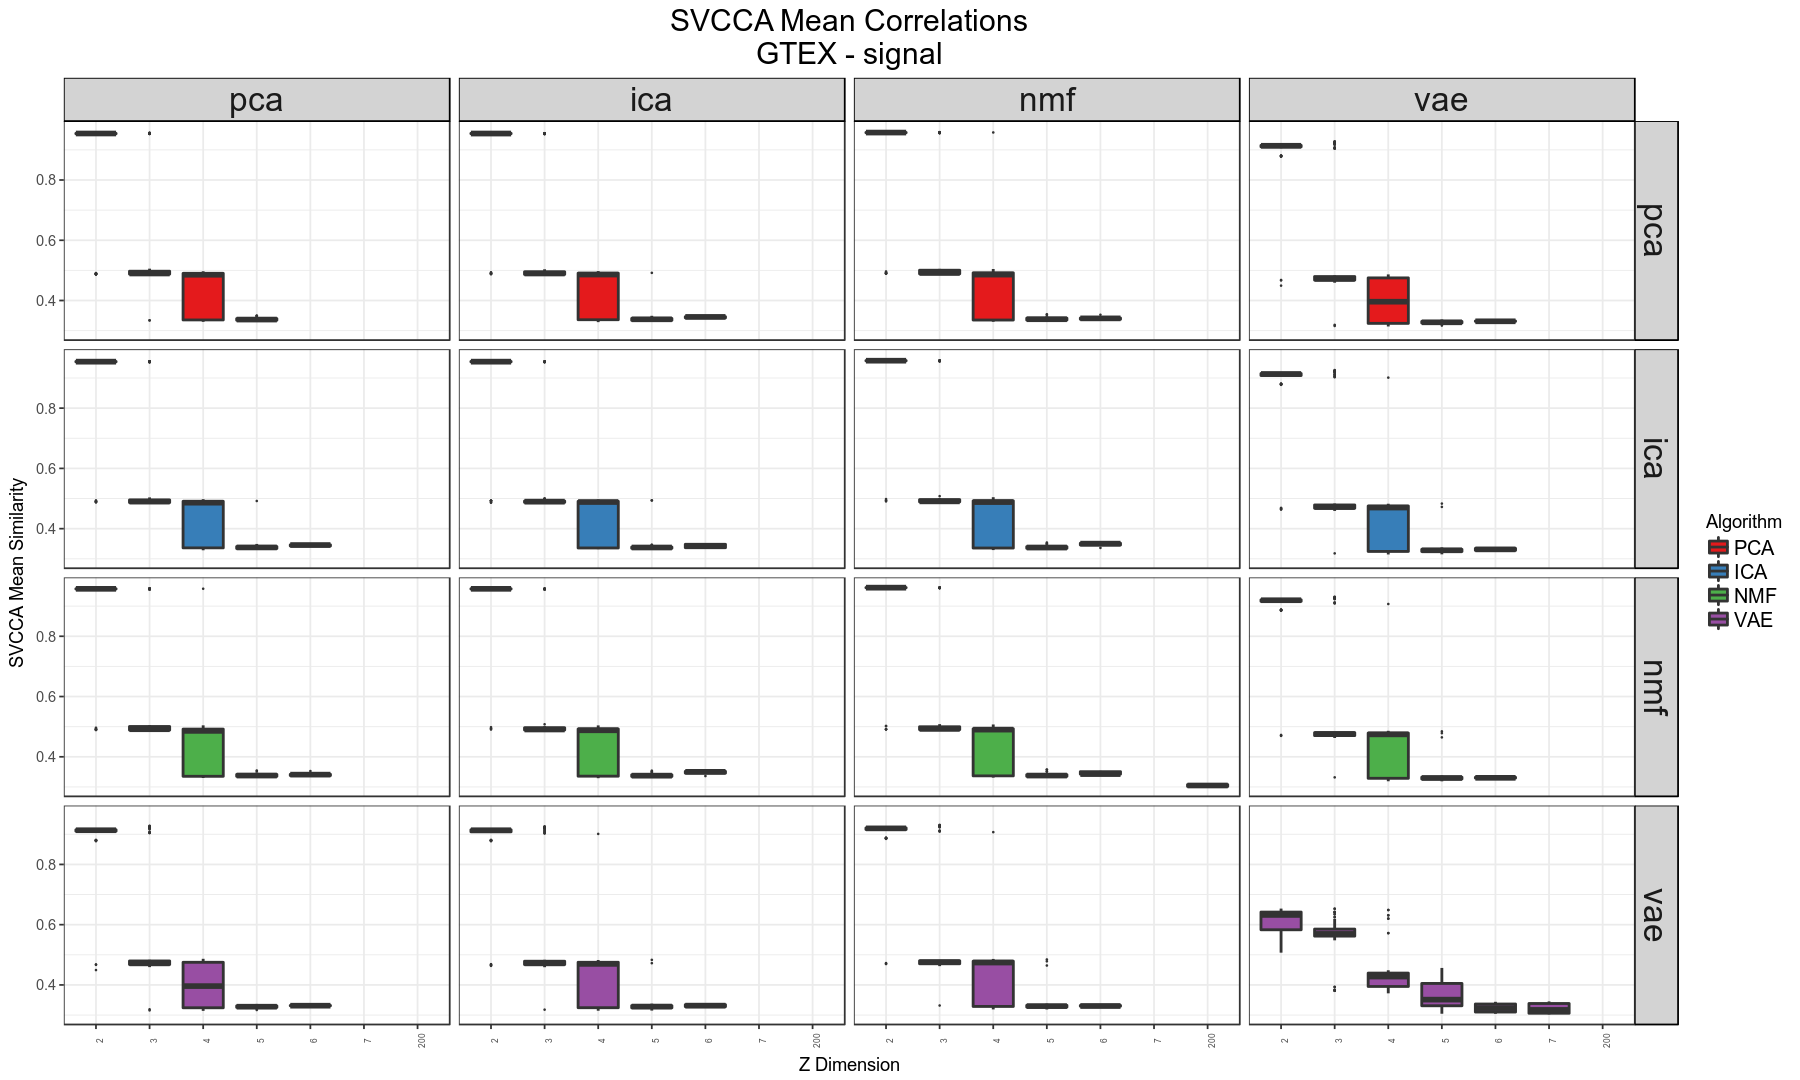

In [4]:
options(repr.plot.width = 15, repr.plot.height = 9)

for (dataset in c("TARGET", "TCGA", "GTEX")) {
    
    for (shuffled in c(TRUE, FALSE)) {
        
        if (shuffled) {
            shuff = "shuffled"
            svcca_subset = 0
        } else {
            shuff = "signal"
            svcca_subset = 0.3
        }
        
        svcca_subset_df <- svcca_df %>%
            dplyr::filter(shuffled == !!shuff,
                          dataset == !!dataset,
                          svcca_mean_similarity >= !!svcca_subset)
        
        out_figure <- file.path("figures", "svcca", paste("within_z",dataset, shuff, sep = '_'))
        plot_title <- paste0("SVCCA Mean Correlations\n", dataset, ' - ', shuff)
        
        g <- ggplot(svcca_subset_df, aes(x = z_dim, y = svcca_mean_similarity, fill = algorithm_1)) +
                geom_boxplot(outlier.size = 0.1, lwd = 0.8) +
                facet_grid(algorithm_1 ~ algorithm_2) +
                xlab("Z Dimension") +
                ylab("SVCCA Mean Similarity") +
                scale_fill_manual(name = "Algorithm",
                                  values = c("#e41a1c",
                                             "#377eb8",
                                             "#4daf4a",
                                             "#984ea3",
                                             "#ff7f00"),
                                  labels = c("pca" = "PCA",
                                             "ica" = "ICA",
                                             "nmf" = "NMF",
                                             "dae" = "DAE",
                                             "vae" = "VAE")) +
                ggtitle(plot_title) +
                theme_bw() +
                theme(axis.text.x = element_text(angle = 90, size = 5),
                      plot.title = element_text(hjust = 0.5, size = 18),
                      legend.text = element_text(size = 12),
                      legend.key.size = unit(1, "lines"),
                      strip.text.x = element_text(size = 20),
                      strip.text.y = element_text(size = 20),
                      strip.background = element_rect(colour = "black", fill = "lightgrey"))
        
        ggsave(plot = g, filename = paste0(out_figure, ".png"), height = 8, width = 12)
        ggsave(plot = g, filename = paste0(out_figure, ".pdf"), height = 8, width = 12)
        
        print(g)
    }
}

## Visualize `across z` SVCCA

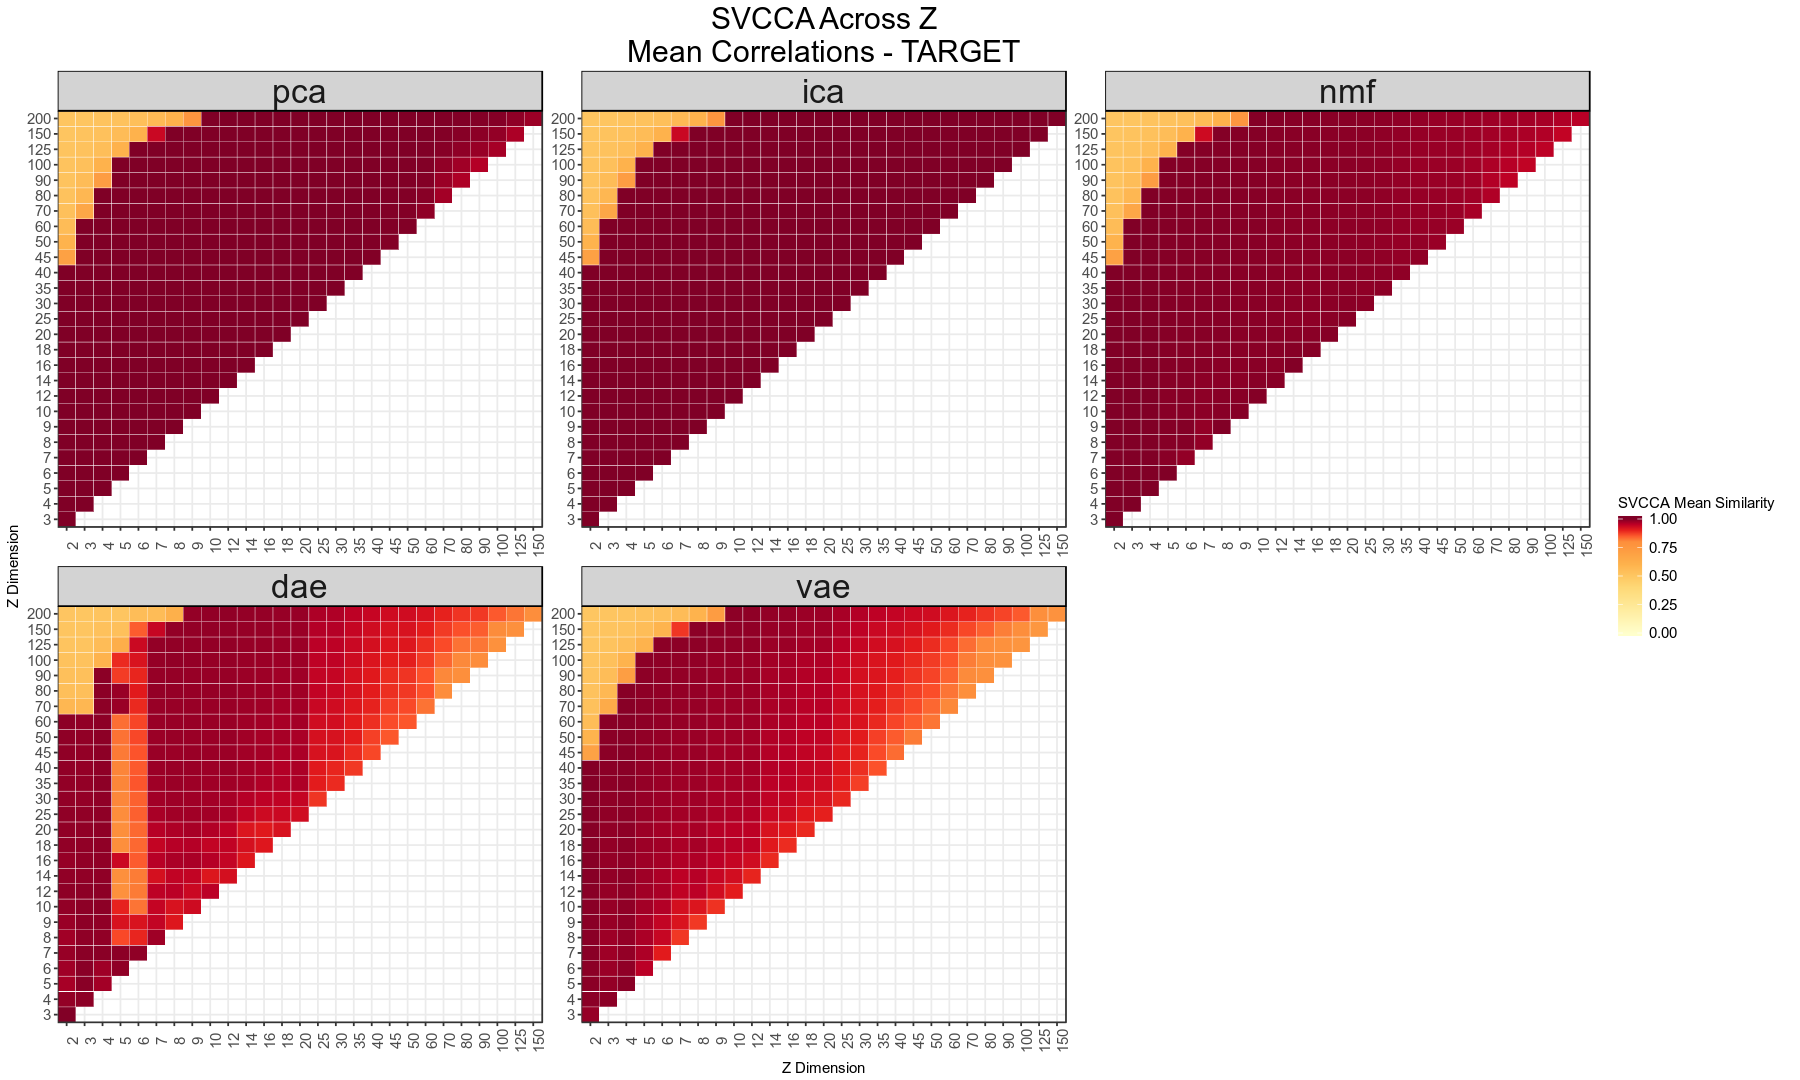

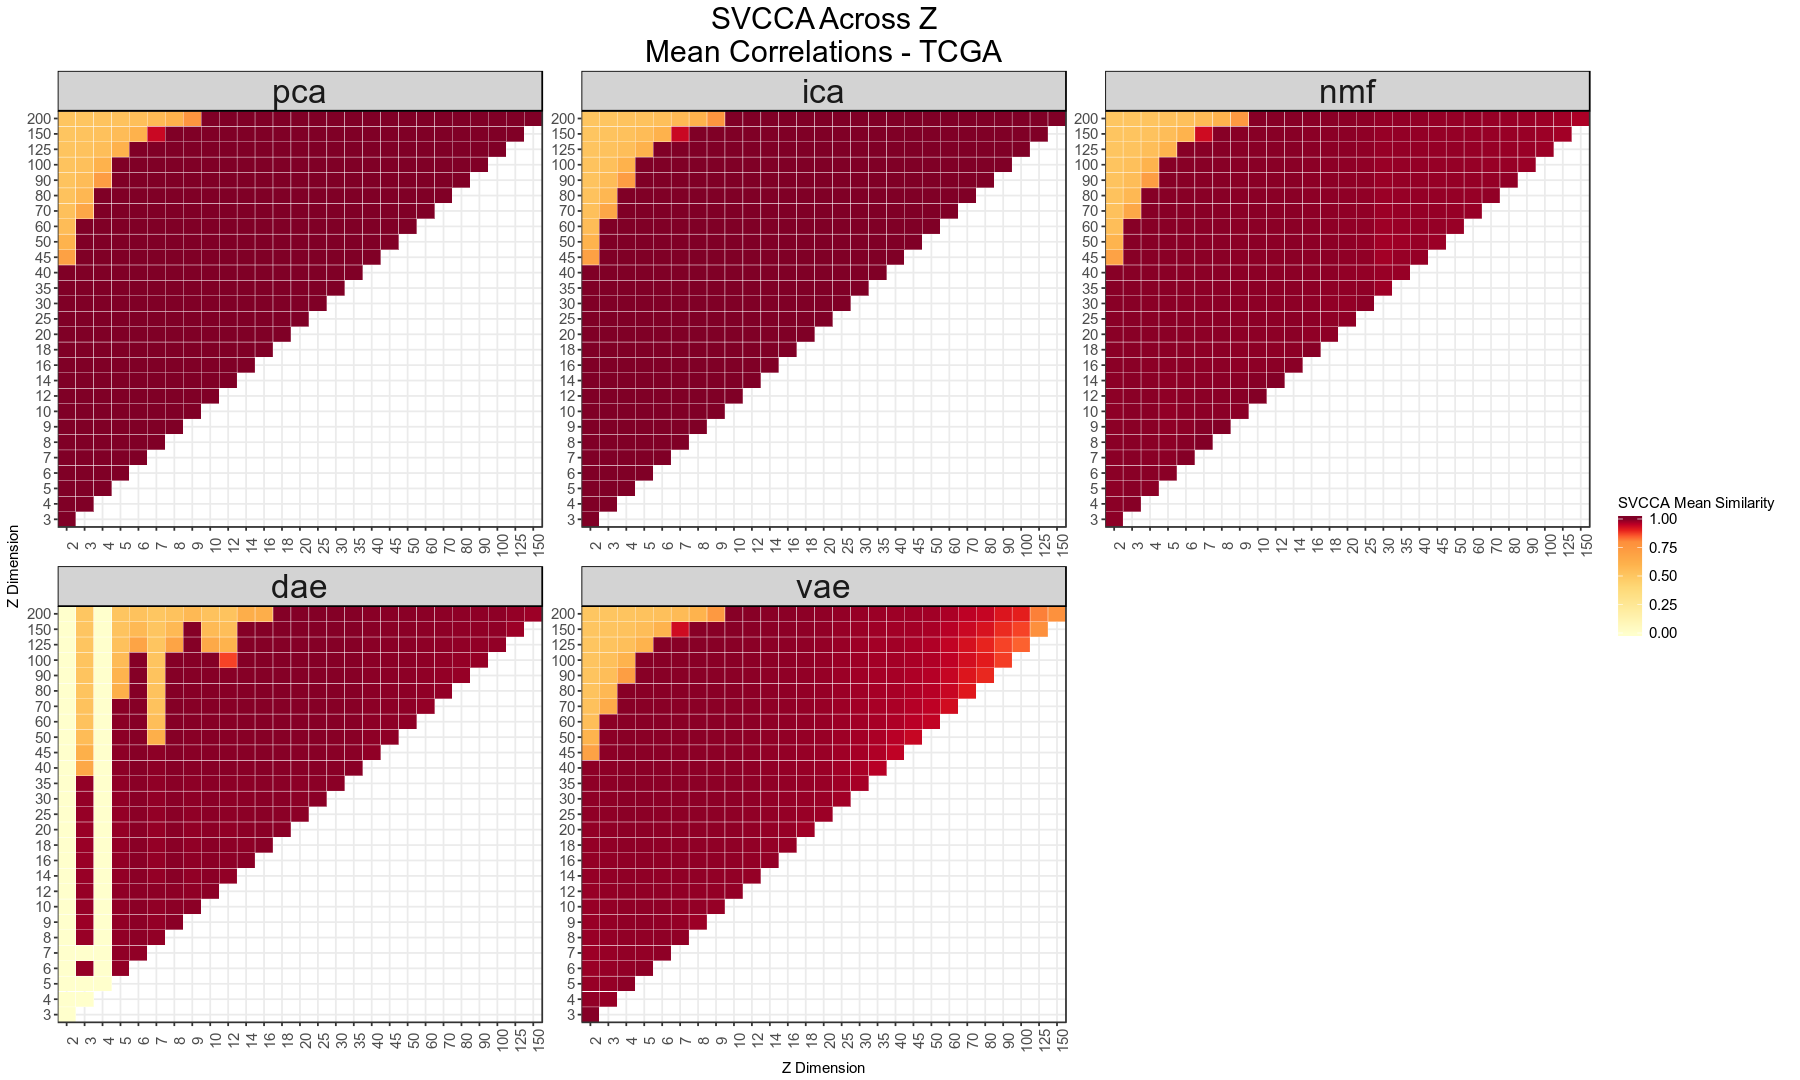

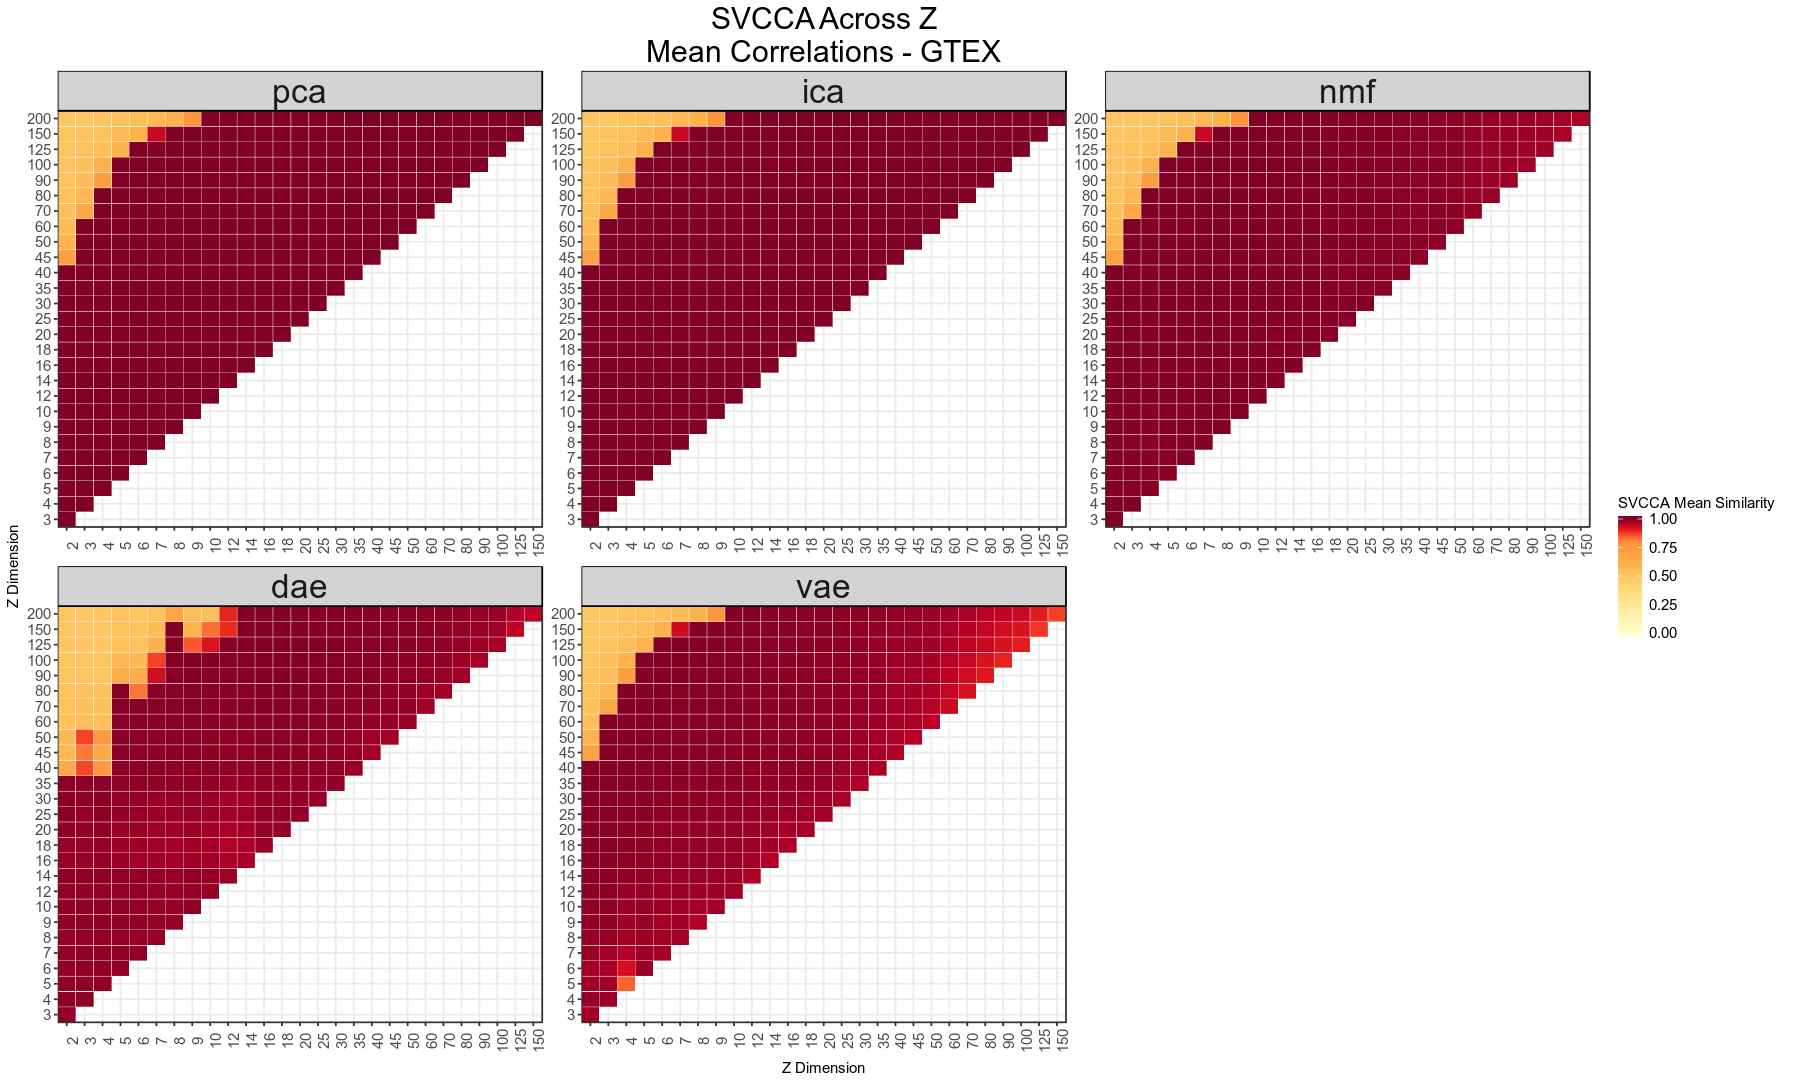

In [5]:
myPalette <- colorRampPalette(rev(brewer.pal(9, "YlOrRd")))

for (dataset in c("TARGET", "TCGA", "GTEX")) {

    # Setup filename
    data_file <- paste0("svcca_", dataset, "_mean_correlation_across_z.tsv.gz")
    data_file = file.path('results', data_file)
    
    # Load file
    svcca_df <- readr::read_tsv(data_file,
                                col_types = readr::cols(
                                .default = readr::col_character(),
                                svcca_mean_similarity = readr::col_double(),
                                z_dim_a = readr::col_integer(),
                                z_dim_b = readr::col_integer()))
        
    # Setup title and output file name
    plot_title <- paste0("SVCCA Across Z\nMean Correlations - ", dataset)
    out_figure <- file.path("figures", "svcca", paste("across_z", dataset, sep = '_'))

    # Make sure factors are in order
    svcca_df$z_dim_a <-
        factor(svcca_df$z_dim_a,
               levels =
                 sort(as.numeric(paste(unique(svcca_df$z_dim_a))))
               )

    svcca_df$z_dim_b <-
        factor(svcca_df$z_dim_b,
               levels =
                 sort(as.numeric(paste(unique(svcca_df$z_dim_b))))
               )

    svcca_df$algorithm <- factor(svcca_df$algorithm, levels = algorithms)
    svcca_df$svcca_mean_similarity <- as.numeric(paste(svcca_df$svcca_mean_similarity))
    
    # Plot and save results
    g <- ggplot(svcca_df, aes(z_dim_a, z_dim_b)) +
            geom_tile(aes(fill = svcca_mean_similarity), colour = "white") +
            coord_equal() +
            scale_fill_gradientn(name = "SVCCA Mean Similarity",
                                 colours = myPalette(100),
                                 values = scales::rescale(c(1, 0.985, 0.92)),
                                 limits = c(0, 1)) +
            facet_wrap(~ algorithm, scales = "free") +
            ggtitle(plot_title) +
            theme_bw(base_size = 9) +
            theme(axis.text.x = element_text(angle = 90, size = 9),
                  axis.text.y = element_text(size = 9),
                  plot.title = element_text(hjust = 0.5, size = 18),
                  legend.text = element_text(size = 9),
                  legend.key.size = unit(1, "lines"),
                  strip.text.x = element_text(size = 20),
                  strip.text.y = element_text(size = 20),
                  strip.background = element_rect(colour = "black", fill = "lightgrey")) +
            xlab("Z Dimension") +
            ylab("Z Dimension") +
            scale_x_discrete(expand = c(0, 0)) +
            scale_y_discrete(expand = c(0, 0))

    ggsave(plot = g, filename = paste0(out_figure, ".png"), height = 8, width = 13)
    ggsave(plot = g, filename = paste0(out_figure, ".pdf"), height = 8, width = 13)

    print(g)
}